In [1]:
from pyspark.sql import SparkSession
sc = SparkSession.builder.getOrCreate()

In [2]:
df = sc.read.load("data.csv", format="csv", sep=",", inferSchema="true", header="true")
df.show()

+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+
|    Country|Year|    Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|        GDP| Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|
+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+
|Afghanistan|2015|Developing|            65.0|            263|           62|

In [3]:
from pyspark.sql.functions import col, isnan, when, count, mean

null_counts = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
null_counts.show()

+-------+----+------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+---+----------+---------------------+-------------------+-------------------------------+---------+
|Country|Year|Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|GDP|Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|
+-------+----+------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+---+----------+---------------------+-------------------+-------------------------------+---------+
|      0|   0|     0|              10|             10|            0|    194|                     0|        553|       0|   34| 

In [4]:
for column in df.columns:
    if dict(df.dtypes)[column]=='double' or dict(df.dtypes)[column]=='int':
        mean_value = df.select(mean(col(column)).alias("mean")).collect()[0]["mean"]
        df = df.fillna(mean_value,subset=[column])



In [5]:
null_counts = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
null_counts.show()

+-------+----+------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+---+----------+---------------------+-------------------+-------------------------------+---------+
|Country|Year|Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|GDP|Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|
+-------+----+------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+---+----------+---------------------+-------------------+-------------------------------+---------+
|      0|   0|     0|               0|              0|            0|      0|                     0|          0|       0|    0| 

In [6]:
df.show()

+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+
|    Country|Year|    Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|        GDP| Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|
+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+
|Afghanistan|2015|Developing|            65.0|            263|           62|

In [7]:
from pyspark.ml.feature import (StringIndexer, OneHotEncoder,StringIndexer,VectorAssembler)

country_indexer = StringIndexer(inputCol='Country',outputCol='CountryIndex')
country_encoder = OneHotEncoder(inputCol='CountryIndex',outputCol='CountryVec')

status_indexer = StringIndexer(inputCol='Status',outputCol='StatusIndex')
status_encoder = OneHotEncoder(inputCol='StatusIndex',outputCol='StatusVec')

In [8]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[country_indexer, status_indexer, 
                            country_encoder, status_encoder])

In [9]:

encoded_df = pipeline.fit(df)
df = encoded_df.transform(df)
df.show()

+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+------------+-----------+---------------+-------------+
|    Country|Year|    Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|        GDP| Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|CountryIndex|StatusIndex|     CountryVec|    StatusVec|
+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+---------

In [10]:
vas = VectorAssembler(inputCols=['CountryVec',
    'StatusVec',
    'Year',
    'Adult Mortality',
    'infant deaths',
    'Alcohol',
    'percentage expenditure',
    'Hepatitis B',
    'Measles ',
    ' BMI ',
    'under-five deaths ',
    'Polio',
    'Total expenditure',
    'Diphtheria ',
    ' HIV/AIDS',
    'GDP',
    'Population',
    ' thinness  1-19 years',
    ' thinness 5-9 years',
    'Income composition of resources',
    'Schooling'],
    outputCol='features')

df = vas.transform(df)
df.show() 

+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+------------+-----------+---------------+-------------+--------------------+
|    Country|Year|    Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|        GDP| Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|CountryIndex|StatusIndex|     CountryVec|    StatusVec|            features|
+-----------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------

In [11]:
df.select('features').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(212,[0,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211],[1.0,1.0,2015.0,263.0,62.0,0.01,71.27962362,65.0,1154.0,19.1,83.0,6.0,8.16,65.0,0.1,584.25921,3.3736494E7,17.2,17.3,0.479,10.1])  |
|(212,[0,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211],[1.0,1.0,2014.0,271.0,

In [12]:
df_train, df_test = df.randomSplit([0.75, 0.25])


In [13]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='Life expectancy ', predictionCol='prediction')

model = lr.fit(df_train)

In [14]:
model.transform(df_train).select('Life expectancy ', 'prediction').show()
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
print("RMSE: " + str(model.summary.rootMeanSquaredError))
print("R2: " + str(model.summary.r2))
#print("Predictions:" + str(lr.summary.predictions))

+----------------+-----------------+
|Life expectancy |       prediction|
+----------------+-----------------+
|            54.8|55.01502141440017|
|            55.3|55.42914049497347|
|            56.7| 56.7363747951307|
|            57.3|57.68428997214858|
|            57.3|58.02755195182624|
|            58.6|58.95851123446835|
|            58.8|59.29339685042578|
|            59.2|59.69724938905324|
|            59.5| 60.0417257114085|
|            59.9|60.30256887219923|
|            59.9|60.57949275551425|
|            65.0|60.52956891856263|
|            73.3|73.74633582379238|
|            72.8|73.97272058787132|
|            73.5|74.47645720734386|
|            74.2|74.80887952886928|
|            75.9|75.10559752525228|
|            76.1|75.46905377172277|
|            76.2|75.86047991653243|
|            76.9|76.50716448411015|
+----------------+-----------------+
only showing top 20 rows

Coefficients: [-11.471767543816387,4.891299812585935,2.7814973765211812,-18.0554803367

Text(0.5, 0, 'Index')

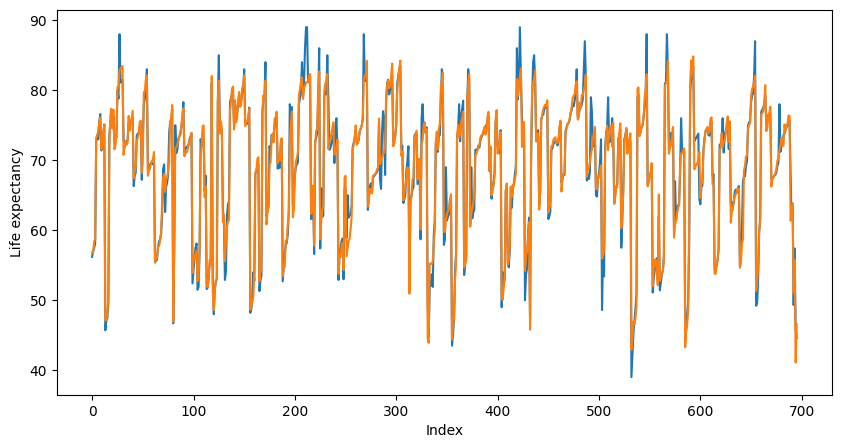

In [15]:
import matplotlib.pyplot as plt

yreal = df_test.select('Life expectancy ').collect()
test = model.transform(df_test)
ypred = test.select('prediction').collect()

plt.figure(figsize=(10,5))

plt.plot(yreal, label='Real')
plt.plot(ypred, label='Predicted')
plt.ylabel('Life expectancy')
plt.xlabel('Index')

In [16]:
print("Coefficients: %s" % str(model.coefficients))
print("Intercept: %s" % str(model.intercept))
print("RMSE: %f" % model.summary.rootMeanSquaredError)
print("R2: %f" % model.summary.r2)

test.select('prediction', 'Life expectancy ').show()

Coefficients: [-11.471767543816387,4.891299812585935,2.7814973765211812,-18.05548033673742,5.402467441168377,4.6472144928809564,3.10856935439416,6.258022592319683,6.52524820720409,0.30093002437614447,4.603146404909764,4.992831664083564,-1.521765563249181,4.155055044643243,0.1387469197578516,5.497844230886256,-0.7335882361749346,-11.49491870594002,-4.5233996438890625,-2.416005916298418,5.823387250105421,-8.049781216172361,2.3175029281821775,5.612947873781587,-2.2270771462001644,-11.954672500868798,-12.601757616578862,2.2072360705616836,-5.8182335575142785,-12.803526615909691,11.298554721614702,-17.634331435013618,-16.510676873632402,8.884846506680047,1.7930044544037789,3.1147112718014442,-8.527528805132222,-8.81284531518206,8.383550731635864,1.1972724556201548,7.213261904933751,4.667821637803647,2.0996277478353327,-17.471720902554438,-0.9497252391249583,-12.614376071652593,3.7930222742392936,-7.498782602750128,2.3669713352669457,4.5676082015866175,0.9444192861335815,1.706132644976053,-1

In [17]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator


paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 1.0, 10.0]) 
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) 
             .build())

In [26]:
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='Life expectancy ', metricName='r2'),
                          numFolds=5)

In [27]:
cvModel = crossval.fit(df_train)


In [28]:
preds = cvModel.transform(df_test)

In [33]:
evaluator = RegressionEvaluator(labelCol='Life expectancy ', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(preds)
print(r2)

0.9599156048199431


Text(0.5, 0, 'Index')

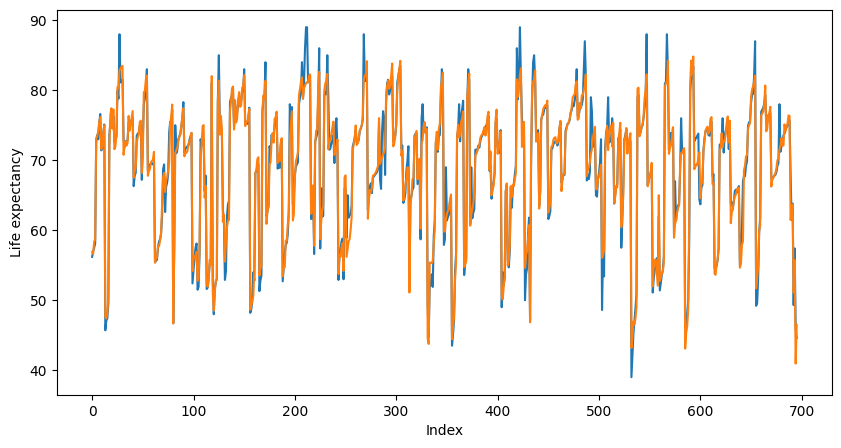

In [38]:
#Get the values from preds and make a plot
yreal = preds.select('Life expectancy ').collect()
ypred = preds.select('prediction').collect()

plt.figure(figsize=(10,5))

plt.plot(yreal, label='Real')
plt.plot(ypred, label='Predicted')
plt.ylabel('Life expectancy')
plt.xlabel('Index')


In [34]:
#print("Best model: ", cvModel.bestModel)
print("Best model coefficients: ", cvModel.bestModel.coefficients)
print("Best model intercept: ", cvModel.bestModel.intercept)
print("Best model RMSE: ", cvModel.bestModel.summary.rootMeanSquaredError)
print("Best model R2: ", cvModel.bestModel.summary.r2)


Best model:  LinearRegressionModel: uid=LinearRegression_ff7705fa4189, numFeatures=212
Best model coefficients:  [-10.226559286559425,5.509118785542974,3.6989329014259247,-17.539911724973358,6.123803411756884,5.316653806472011,3.766664210702293,6.448187578266393,6.795589356441526,1.018589920385659,5.21944911157581,5.660962583474916,0.19719924452077428,4.787834027075761,0.7557555560658585,5.689474553574079,-0.05159062668468919,-10.720523702441037,-3.447545187335058,-1.7422170611009307,6.5080250642783595,-7.18686699223524,3.6272636176685573,6.290041928667647,-1.906394497854927,-11.593153066989798,-11.763437493395513,3.0072328240855795,-4.775468734260571,-12.16406942551296,11.816164331263108,-16.667879769261702,-16.055049995419182,9.463875434445848,5.455009691266741,3.8936069919250174,-7.6395629154009885,-7.926207472489064,9.013184295848022,1.4844129142817273,7.848404757521344,4.929537103475209,2.4258365014399277,-16.56340366736824,-0.15988967600407897,-11.032587920023449,4.00061626889299

In [35]:
best_model = cvModel.bestModel
best_reg_param = best_model._java_obj.getRegParam()
best_elastic_net_param = best_model._java_obj.getElasticNetParam()
print(f'Best Regularization Parameter (regParam): {best_reg_param}')
print(f'Best ElasticNet Parameter (elasticNetParam): {best_elastic_net_param}')

Best Regularization Parameter (regParam): 0.01
Best ElasticNet Parameter (elasticNetParam): 0.0
